In [1]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import ot
import os
from tqdm import tqdm

In [2]:
file_path = '../../../data/BPI Challenge 2017.xes'
event_log = pm4py.read_xes(file_path)

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [ ]:
drbart_schedule_start = DRBART(parser_dir = '../../models/bpic_2017_schedule_start/concept-name_resource_seconds-in-day_activity-count_resource_count/')
drbart_start_suspend = DRBART(parse_dir = '../../models/bpic_2017_start_suspend/concept-name_resource_seconds-in-day_activity-count/')
drbart_suspend_resume = DRBART(parse_dir = '../../models/bpic_2017_suspend_resume/concept-name_resource_seconds-in-day_activity-count_resource_count/')

def sample_schedule_start_time(seconds_in_day, resource_count, activity_count):
    known_resources = ['User_10','User_100','User_101','User_102','User_103','User_104','User_105','User_106','User_107','User_108','User_109','User_11','User_110','User_111','User_112','User_113','User_114','User_115','User_116','User_117','User_118','User_119','User_12','User_120','User_121','User_122','User_123','User_124','User_125','User_126','User_127','User_129','User_13','User_130','User_131','User_132','User_133','User_134','User_135','User_136','User_137','User_138','User_14','User_140','User_141','User_142','User_143','User_144','User_15','User_16','User_17','User_18','User_19','User_2','User_20','User_21','User_22','User_23','User_24','User_25','User_26','User_27','User_28','User_29','User_3','User_30','User_31','User_32','User_33','User_34','User_35','User_36','User_37','User_38','User_39','User_4','User_40','User_41','User_42','User_43','User_44','User_45','User_46','User_47','User_48','User_49','User_5','User_50','User_51','User_52','User_53','User_54','User_55','User_56','User_57','User_58','User_59','User_6','User_60','User_61','User_62','User_63','User_64','User_65','User_66','User_67','User_68','User_69','User_7','User_70','User_71','User_72','User_73','User_74','User_75','User_76','User_77','User_78','User_79','User_8','User_80','User_81','User_82','User_83','User_84','User_85','User_86','User_87','User_88','User_89','User_9','User_90','User_91','User_92','User_93','User_94','User_95','User_96','User_97','User_98','User_99']
    known_activities = ['W_Assess.potential.fraud','W_Call.after.offers','W_Call.incomplete.files','W_Complete.application','W_Handle.leads','W_Validate.application']

    return drbart_schedule_start.sample([resource,
                                         concept_name,
                                         *[0 if resource not in resource_count for resource in known_resources else resource_count[resource]],
                                         *[0 if activity not in activity_count for activity in known_activities else activity_count[activity]]
                                        ],
                                        [seconds_in_day])[0]

def sample_start_complete_time(seconds_in_day, resource_count, activity_count):
    
sample_start_complete_time = lambda : 50
sample_resume_time = lambda : 25
event_log['duration_sampled'] = event_log.apply(lambda x : int(round(
                                                drbart.sample([x['org:resource']],
                                                              [])[1][0]
                                                                                ,0)), axis=1)

In [3]:
event_log

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202262,Deleted,User_1,W_Call after offers,Workflow,Workitem_1817549786,ate_abort,2017-01-06 06:33:02.212000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202263,Created,User_1,W_Call after offers,Workflow,Workitem_363876066,schedule,2017-01-06 06:33:02.221000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202264,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1202265,statechange,User_28,O_Cancelled,Offer,OfferState_420066181,complete,2017-01-16 09:51:21.139000+00:00,Home improvement,New credit,Application_1350494635,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offer_1580299144


In [15]:
example_application = event_log[event_log['case:concept:name'] == 'Application_652823628'].copy()
example_application['new_concept'] = example_application['concept:name'] +  '__' + example_application['EventID'] + '__' + example_application['lifecycle:transition']
example_application = example_application[example_application['concept:name'].str.startswith('W_')]
example_application

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID,new_concept
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_Handle leads__Workitem_1298499574__schedule
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_Handle leads__Workitem_1673366067__withdraw
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_Complete application__Workitem_1493664571__s...
6,Obtained,User_17,W_Complete application,Workflow,Workitem_1875340971,start,2016-01-02 10:45:22.429000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_Complete application__Workitem_1875340971__s...
7,Released,User_17,W_Complete application,Workflow,Workitem_1452291795,suspend,2016-01-02 10:49:28.816000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_Complete application__Workitem_1452291795__s...
12,Deleted,User_52,W_Complete application,Workflow,Workitem_1007505836,ate_abort,2016-01-02 11:30:28.621000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_Complete application__Workitem_1007505836__a...
13,Created,User_52,W_Call after offers,Workflow,Workitem_1087320491,schedule,2016-01-02 11:30:28.629000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_Call after offers__Workitem_1087320491__sche...
14,Obtained,User_52,W_Call after offers,Workflow,Workitem_719909876,start,2016-01-02 11:30:28.631000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_Call after offers__Workitem_719909876__start
16,Released,User_52,W_Call after offers,Workflow,Workitem_1447720177,suspend,2016-01-02 11:32:41.624000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_Call after offers__Workitem_1447720177__suspend
17,Obtained,User_11,W_Call after offers,Workflow,Workitem_1260329040,resume,2016-01-06 09:26:44.492000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W_Call after offers__Workitem_1260329040__resume


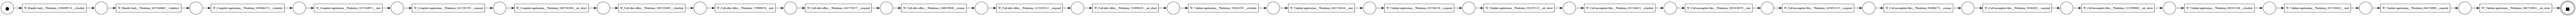

In [21]:

#test_log = example_application[(test_log['lifecycle:transition'] == 'start') | (test_log['lifecycle:transition'] == 'complete')]
net, im, fm = pm4py.discover_petri_net_inductive(example_application, activity_key='new_concept', case_id_key='case:concept:name', timestamp_key='time:timestamp')
pm4py.view_petri_net(net, im, fm)


In [57]:
from pm4py.objects.petri_net import semantics


get_enabled_tasks = lambda marking : list(semantics.enabled_transitions(net, marking))

marking = im
case_name = 'Application_652823628'
real_time =  event_log[(event_log['case:concept:name'] == case_name) & (event_log['concept:name'] == task) & (event_log['EventID'] == workitem) & (event_log['lifecycle:transition'] == action)]['time:timestamp'].astype(int).iloc[0]
current_time = real_time

sample_schedule_start_time = lambda : 100
sample_start_complete_time = lambda : 50
sample_resume_time = lambda : 25

sample_time = lambda : 50
finish_time = dict()

while get_enabled_tasks(marking):
    pn_task = get_enabled_tasks(marking)[0]
    task, workitem, action = pn_task.label.split('__')
    print(current_time, task, workitem, action,
          real_time)
    
    if action == 'schedule':
        finish_time[task] = current_time + sample_schedule_start_time()
    elif action == 'start':
        finish_time[task] = finish_time[task] + sample_start_complete_time()
    elif action == 'suspend':
        finish_time[task] = finish_time[task] + sample_resume_time()
    else:
        current_time = max(current_time, finish_time[task])
    marking = semantics.execute(pn_task, net, marking)
    real_time = event_log[(event_log['case:concept:name'] == case_name) & (event_log['concept:name'] == task) & (event_log['EventID'] == workitem) & (event_log['lifecycle:transition'] == action)]['time:timestamp'].astype(int).iloc[0]
print(current_time)
print(finish_time)

1452786551423000000 W_Handle leads Workitem_1298499574 schedule 1452786551423000000
1452786551423000000 W_Handle leads Workitem_1673366067 withdraw 1451641875774000000
1452786551423000100 W_Complete application Workitem_1493664571 schedule 1451641956392000000
1452786551423000100 W_Complete application Workitem_1875340971 start 1451641956403000000
1452786551423000100 W_Complete application Workitem_1452291795 suspend 1451731522429000000
1452786551423000100 W_Complete application Workitem_1007505836 ate_abort 1451731768816000000
1452786551423000275 W_Call after offers Workitem_1087320491 schedule 1451734228621000000
1452786551423000275 W_Call after offers Workitem_719909876 start 1451734228629000000
1452786551423000275 W_Call after offers Workitem_1447720177 suspend 1451734228631000000
1452786551423000275 W_Call after offers Workitem_1260329040 resume 1451734361624000000
1452786551423000450 W_Call after offers Workitem_1152103512 suspend 1452072404492000000
1452786551423000450 W_Call aft